# Vertically Integrated Heat Content and tendency accumulation in ACCESS-OM2

### Theory
Consider the vertically-integrated heat budget:

\begin{equation}
\frac{\partial H}{\partial t}(x,y,t) = T + Q, \label{dHdt}
\end{equation}

where, $$H(x,y,t) = \int_{-H}^\eta \rho_0 C_p \Theta dz$$ is the vertically-integrated heat content (Jm$^{-2}$), $T=-\nabla_h\cdot\mathbf{F}_O$ is the convergence of the vertically-integrated horizontal ocean heat transport ($\mathbf{F}_O$) and $Q$ is the net surface heat flux (both Wm$^{-2}$).

Integrating Eq. $\eqref{dHdt}$ between two times $t_1$ and $t_2$ yields:
$$\Delta_{t_1}^{t_2} H = H(x,y,t_2)-H(x,y,t_1) = \int_{t_1}^{t_2} T dt + \int_{t_1}^{t_2} Q dt = (t_2-t_1)(\overline{T}+\overline{Q})$$
Thus the change in heat content is given by the average of the ocean heat transport and surface heat flux tendency terms over the interim period multiplied by the length of that interim period.

There are two problems with using the above equation:

1. A large cancelation between $\overline{T}$ and $\overline{Q}$ means that $\Delta H$ is unlikely to look like either $\overline{T}$ or $\overline{Q}$. One option to deal with this is to subtract off some type of average ocean heat transport $T_A$ (we choose $T$ rather than $Q$ for this because it integrates globally to zero):
$$\Delta_{t_1}^{t_2}H = (t_2-t_1)(\overline{T}-T_A)+(t_2-t_1)(\overline{Q}+T_A) = (t_2-t_1)\Delta T + (t_2-t_1)\Delta Q$$
Obviously if we pick $T_A=\overline{T}$ then we get back to the previous equation. The best pick for $T_A$ would be a long-term average from a balanced PI-control run or a pre-CC period.

2. The change in heat content is sensitive to short time-scale variability because the end periods are snapshots.

To deal with the second issue, a better approach would be to consider the change in heat content between two decadal-scale averaging windows $(t_{11},t_{12})$ and $(t_{21},t_{22})$, where we assume for simplicity that $t_{22}-t_{21}=t_{12}-t_{11}=\Delta t$. The change in heat content between these two periods obeys,

\begin{align}
\Delta_{t_{11},t_{12}}^{t_{21},t_{22}} H &= \frac{1}{\Delta t}\int_{t_{21}}^{t_{22}} H dt - \frac{1}{\Delta t}\int_{t_{11}}^{t_{12}} H dt \\
&= \frac{1}{\Delta t}\int_{t_{21}}^{t_{22}} \left(H(t) - H(t_{21})\right) dt +H(t_{21}) + \frac{1}{\Delta t}\int_{t_{11}}^{t_{12}} \left(H(t_{12}) -H(t)\right) dt -H(t_{12}) \\
&= \frac{1}{\Delta t}\int_{t_{21}}^{t_{22}} \int_{t_{21}}^t \left(T+Q\right) dt' dt + \frac{1}{\Delta t}\int_{t_{11}}^{t_{12}} \int_{t}^{t_{12}} \left(T+Q\right) dt' dt + \int_{t_{12}}^{t_{21}} \left(T+Q\right) dt \\
&= -\frac{1}{\Delta t}\int_{t_{21}}^{t_{22}} \int_{t}^{t_{22}} \left(T+Q\right) dt' dt - \frac{1}{\Delta t}\int_{t_{11}}^{t_{12}} \int_{t_{11}}^t \left(T+Q\right) dt' dt + \int_{t_{11}}^{t_{22}} \left(T+Q\right) dt \\
\end{align}

The second last line expresses the change in heat content in terms of the transport and surface heat fluxes over the interim period (last term), and over the individual window-averaging periods (first two terms, which involve double time integrals). The last line rewrites this in terms of the transport and surface heat fluxes over the whole period (last term). Further, we can integrate the two time integrals by parts to turn them into single time-integrals,

\begin{align}
\int_{t_{21}}^{t_{22}}\int_t^{t_{22}}(T+Q)dt'dt &= \int_{t_{21}}^{t_{22}}(t-t_{21})(T+Q)dt \\
\int_{t_{11}}^{t_{12}}\int_{t_{11}}^t(T+Q)dt'dt &= \int_{t_{11}}^{t_{12}}(t_{12}-t)(T+Q)dt \\
\end{align}

Substituting these in above yields,
\begin{equation}
\Delta_{t_{11},t_{12}}^{t_{21},t_{22}} H = -\frac{1}{\Delta t}\int_{t_{21}}^{t_{22}} (t-t_{21})\left(T+Q\right) dt + \frac{1}{\Delta t}\int_{t_{11}}^{t_{12}} (t-t_{12})\left(T+Q\right) dt + \int_{t_{11}}^{t_{22}} \left(T+Q\right) dt
\end{equation}

This shows that $\Delta H$ can also be interpreted as the full-average (last term) minus a rising and a falling weighted-average over the first and last periods. There are various other ways to write this. For example, one intuitive way is,

\begin{equation}
\Delta_{t_{11},t_{12}}^{t_{21},t_{22}} H = -\frac{1}{\Delta t}\int_{t_{21}}^{t_{22}} (t-t_{21})\left(T+Q\right) dt + \frac{1}{\Delta t}\int_{t_{11}}^{t_{12}} (t-t_{11})\left(T+Q\right) dt +\int_{t_{12}}^{t_{22}} \left(T+Q\right) dt
\end{equation}

I.e. an integral from the end of the first period to the end of the second period (last term), plus a rising integral over the first period (second term), subtracting a rising integral over the last period (first term). This form clearly shows that in terms of diagnostic code accumulation, we would only need to accumulate averages of $T+Q$ (already in place) and averages of $(t-t_i)(T+Q)$ where $t_i$ is the time at the beginning of the diagnostic accumulation period.

This type of average has been very roughly implemented (i.e. hacked) into MOM5 using the `diag_manager` from FMS as described below.

### Rising average maths in `diag_manager`

We wish to accumulate a rising average (denoted by $\overline{x}^r$) over the given diagnostic time period. In order to accumulate an average (as opposed to a sum in the last equation above) we need to divide by the diagnostic time period $\Delta t=t_f-t_0$ again. I.e., for a given quantity $A$ (say the surface heat flux in Wm$^{-2}$ above) we wish to calculate

\begin{equation}
\overline{A}^r \equiv \frac{1}{(\Delta t)^2}\int_{t_0}^{t_f}(t-t_0)A dt
\end{equation}

where $t_0$ and $t_f$ are the times at the beginning and ending of the diagnostic time period. Written as a discrete sum this is,

\begin{equation}
\overline{A}^r \equiv\frac{\Sigma_{i=1}^n(i - 1/2) dt A_i dt}{\left[\Sigma_{i=1}^n dt\right]^2}
\end{equation}

where $i$ is the step number, $dt$ is the time step and the $-1/2$ indicates that the time should be that associated with the middle of the time step (as A is accumulated over that time step).

Currently, the standard `average` method in `diag_manager` accumulates average variables $\overline{x}$ using the following maths

\begin{equation}
\overline{A} \equiv \frac{1}{\Delta t}\int_{t_0}^{t_f}A dt = \frac{A_c}{C} = \frac{\Sigma_{i=1}^n w_i A_i}{\Sigma_{i=1}^n w_i}
\end{equation}

where $w_i=1$ for the standard average. 

We can take advantage of this weighting system to approximately implement the rising average with very little code. We introduce a new option `risavg` that instead sets the weights equal to the time elapsed since the previous output,

\begin{equation}
w_i = t-t_0 = i dt
\end{equation}

where $dt$ is the time step. This should strictly be $(i-1/2)dt$ but that form is more difficult to implement. With this choice of $w_i$ the accumulated sum $A_C$ and the count $C$ become,

\begin{equation}
A_c = \Sigma_{i=1}^n i dt A_i, C = \Sigma_{i=1}^n i dt 
\end{equation}

To obtain an approximate discrete form of $\overline{A}^r$ above from these quantities we use the fact that,

\begin{equation}
C = dt \frac{n(n+1)}{2} \approx dt \frac{n^2}{2} = \frac{(\Sigma_{i=1}^n dt)^2}{2 dt}
\end{equation}

where the approximation holds for large $n$. Simlarly, the $-1/2$ can be dropped in the discrete form of $\overline{A}^r$ above for large $n$ yielding,

\begin{equation}
\overline{A}^r \approx \frac{dt A_c}{2 dt C} = \frac{A_c}{2C}
\end{equation}
where again, this only holds in the limit of large $n$. To achieve this in `diag_manager.F90` simply requires modifying the weights as above, and dividing by the factor of $2$ when the averaging count division is done. This rough hack is done in the `vitime` branch of my [MOM5 fork](https://github.com/rmholmes/MOM5/tree/vitime).

To remove the approximation that $n$ be large requires a more difficult coding exercise that can't (I don't think) just take advantage of the weights system in `diag_manager.F90`.


## Detrending tendencies

It's not obvious how to deal with tendencies when detrending a perturbation run from a drifiting control run. Once again, the tendencies relate to the difference in snapshots - so if the detrending is done using either the snapshots themselves (?confirm?), or a linear line that starts at the first snapshot and ends at the last snapshot (meaning that the detrending tendencies are simply the average tendencies over the full interim period) then there is no problem. However, if the detrending is instead done using a linear (or higher-order) fit to either the snapshots or the means (as it should be!), then it is not clear how to then calculate perturbation tendencies. This is a related problem to above and would be good to address in this study.


Consider two heat content time series, a control run $H_c(t)$ and a perturbation (e.g. historical) run $H_p(t)$ (both in Joules). Written in terms of a total heat flux into the ocean $Q$(t) (in Watts)

\begin{align}
H_p(t) &= H_p(t_0) + \int_{t_0}^t Q_p(t') dt' \\
H_c(t) &= H_c(t_0) + \int_{t_0}^t Q_c(t') dt',\label{HcEq}
\end{align}

The simple difference evolves according to the time-integrated tendency difference:

\begin{equation}
(H_p-H_c)(t) = (H_p-H_c)(t_0) + \int_{t_0}^t Q_p(t') - Q_c(t') dt'
\end{equation}

However, lets say we instead de-drift $H_p$ with some kind of fit (linear, quadratic) $H_F(t)$ to $H_c(t)$. Let's write $H_F(t) = \mathcal{F}(H_c(t))$ as an operator for this fit. Clearly, the new perturbation heat content will not satisfy the following,

\begin{equation}
(H_p-H_F)(t) \neq!!!\quad (H_p-H_F)(t_0) + \int_{t_0}^t Q_p(t') - \mathcal{F}(Q_c(t')) dt',
\end{equation}

because the operator $\mathcal{F}$ does not in general commute with the time-integral.

HOWEVER - if one were to instead drift the time-integrated $Q$, i.e. $\mathcal{F}(\int_{t_0}^t Q_c(t') dt')$ then there should be no problems (providing the same operator is used on $H_c(t)$). I.e.

\begin{equation}
H_L(t) = \mathcal{F}(H_c(t)) = \mathcal{F}(H_c(t_0) + \int_{t_0}^t Q_c(t') dt')
\end{equation}

Yes this works - probably can disregard the rest of this...

### End-to-end operator

For the ACCESS-OM2 run I use an end-to-end operator $\mathcal{F}^{ee}$ as follows,

\begin{equation}
H_{ee}(t) = \mathcal{F}^{ee}(H_c(t)) \equiv H_c(t_0) + (H_c(t_1)-H_c(t_0))\frac{t-t_0}{t_1-t_0}
\end{equation}

In which case the use of Eq. \eqref{HcEq} reveals,
\begin{equation}
H_{ee}(t) = H_{ee}(t_0) + \overline{Q}_c(t-t_0)
\end{equation}

where $\overline{Q}_c = \frac{1}{t_1-t_0}\int_{t_0}^{t_1} Q_c dt$ is the time-averaged tendency over the full period. In this case it is easy to derive the evolution equation for $H_p-H_{ee}$:

\begin{equation}
(H_p-H_{ee})(t) = (H_p-H_{ee})(t_0) + \int_{t_0}^t Q_p(t') - \overline{Q}_c dt'
\end{equation}

However, we note that $\overline{Q}_c\neq\mathcal{F}^{ee}(Q_c)$.

### Linear fit

A linear fit to $H_c(t)$ is given by:
\begin{equation}
H_L(t) = A t + B
\end{equation}

where,
\begin{align}
    A &= \frac{\int_{t_0}^{t_1} (H_c-\overline{H}_c)(t-\overline{t})dt}{\int_{t_0}^{t_1} (t-\overline{t})^2 dt}, \\
    B &= \overline{H}_c-A\overline{t},
\end{align}

and  $\overline{H}_c=\frac{1}{t_1-t_0}\int_{t_0}^{t_1}H_c(t) dt$, $\overline{t} = (t_1-t_0)/2$. Clearly, in this case the correct tendency to subtract off is $A$. I.e.

\begin{equation}
(H_p-H_L)(t) = H_p(t_0)-A t_0 -B + \int_{t_0}^t \left(Q_p(t) - A\right) dt
\end{equation}

However, $A$ is certainly not the linear fit to $Q_c$, or $\overline{Q}_c$. Is is also not clear if $Q$ has multiply components (i.e. we are looking at an intermediate temperature, in which case both surface forcing and mixing can contribute) how we deal with these individual components. 

How can we write $H_L(t)$ in terms of $Q_c$? As far as I've gotten so far:

\begin{equation}
A = \frac{1}{\int_{t_0}^{t_1} (t-\overline{t})^2 dt}\left(\int_{t_0}^{t_1}\int_{t_0}^t Q_c(t')(t-\overline{t})dt'dt -
\int_{t_0}^{t_1}\int_{t_0}^{t_1}(t_1-t')Q_c(t')(t-\overline{t})dt' dt\right)
\end{equation}

Integration by parts will be the next step...

## Analysis

### Preamble
load packages and associated...

In [1]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import cftime

import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import sys, os
import warnings
warnings.simplefilter("ignore") 

import cosima_cookbook as cc

from dask.distributed import Client

In [2]:
# Load workers:
client = Client(n_workers=8)
client

Client Scheduler: tcp://127.0.0.1:35129 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 33.67 GB


In [3]:
# Load session 
session = cc.database.create_session('../cc_database_1deg.db')

In [4]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [5]:
# Define experiments
from collections import OrderedDict
exptdict = OrderedDict([
    ('1degRYFvitest',   {'model':'ACCESS-OM2 RYF', 'expt':'1deg_jra55_ryf_vitest',
                'n_files':-1, 'itime': None,'ftime':None}),
])

### Structure data
Here we extract variables. We use vertical sums of the 3D tendency diagnostics to be sure of closure (see below for a test). Both normal averaging and rising-averaging (from `ocean_risavg.nc` or with the suffix `ra`) variables are loaded, along with heat content snapshots.

The first cell sets the structures, the second cell actually loads the variables.

In [6]:
ekey = '1degRYFvitest'
expt = exptdict[ekey]['expt']
n_files = exptdict[ekey]['n_files']

rho0 = 1035. # kgm-3
Cp = 3992.10322329649 # J kg-1 degC-1

A = cc.querying.getvar(expt,'area_t',session,n=n_files,decode_times=False,ncfile='ocean_grid.nc')

# timing
dt = 86400.*cc.querying.getvar(expt,'average_DT',session,n=n_files,decode_times=False,ncfile='ocean_month.nc')
time_avg = cc.querying.getvar(expt, 'time',session, n=n_files,ncfile='ocean_month.nc')
time_snap = cc.querying.getvar(expt, 'time',session, n=n_files,ncfile='ocean_snap.nc')

# scalars
Hg_scl = 1.e25*cc.querying.getvar(expt, 'total_ocean_heat',session, n=n_files,decode_times=False
                       ,ncfile='ocean_scalar.nc')

# heat content
H = Cp*cc.querying.getvar(expt, 'temp_int_rhodz',session, n=n_files,decode_times=False
                       ,ncfile='ocean_month.nc') # J m-2
Hsnap = Cp*cc.querying.getvar(expt, 'temp_int_rhodz',session, n=n_files,decode_times=False
                       ,ncfile='ocean_snap.nc') # J m-2

# tendency
TEN = cc.querying.getvar(expt, 'temp_tendency',session, n=n_files,decode_times=False
                       ,ncfile='ocean_heat.nc').sum('st_ocean')
TENra = cc.querying.getvar(expt, 'temp_tendency',session, n=n_files,decode_times=False
                       ,ncfile='ocean_risavg.nc').sum('st_ocean')

# surface fluxes
Q = cc.querying.getvar(expt, 'sw_heat',session, n=n_files,decode_times=False
                       ,ncfile='ocean_heat.nc').sum('st_ocean') + \
    cc.querying.getvar(expt, 'temp_vdiffuse_sbc',session, n=n_files,decode_times=False
                       ,ncfile='ocean_heat.nc').sum('st_ocean') + \
    cc.querying.getvar(expt, 'sfc_hflux_pme',session, n=n_files,decode_times=False
                       ,ncfile='ocean_heat.nc') + \
    cc.querying.getvar(expt, 'frazil_3d',session, n=n_files,decode_times=False
                       ,ncfile='ocean_heat.nc').sum('st_ocean') + \
    cc.querying.getvar(expt, 'temp_eta_smooth',session, n=n_files,decode_times=False
                       ,ncfile='ocean_heat.nc') + \
    cc.querying.getvar(expt, 'temp_rivermix',session, n=n_files,decode_times=False
                       ,ncfile='ocean_heat.nc').sum('st_ocean')
# ocean transport
T = cc.querying.getvar(expt, 'temp_advection',session, n=n_files,decode_times=False
                       ,ncfile='ocean_heat.nc').sum('st_ocean') + \
    cc.querying.getvar(expt, 'temp_submeso',session, n=n_files,decode_times=False
                       ,ncfile='ocean_heat.nc').sum('st_ocean') + \
    cc.querying.getvar(expt, 'neutral_diffusion_temp',session, n=n_files,decode_times=False
                       ,ncfile='ocean_heat.nc').sum('st_ocean') + \
    cc.querying.getvar(expt, 'neutral_gm_temp',session, n=n_files,decode_times=False
                       ,ncfile='ocean_heat.nc').sum('st_ocean') + \
    cc.querying.getvar(expt, 'mixdownslope_temp',session, n=n_files,decode_times=False
                       ,ncfile='ocean_heat.nc').sum('st_ocean') + \
    cc.querying.getvar(expt, 'temp_sigma_diff',session, n=n_files,decode_times=False
                       ,ncfile='ocean_heat.nc').sum('st_ocean')
    
# Vertical transport (should be zero)
Vf = cc.querying.getvar(expt, 'temp_vdiffuse_diff_cbt',session, n=n_files,decode_times=False
                       ,ncfile='ocean_heat.nc').sum('st_ocean') + \
    cc.querying.getvar(expt, 'temp_nonlocal_KPP',session, n=n_files,decode_times=False
                       ,ncfile='ocean_heat.nc').sum('st_ocean') + \
    cc.querying.getvar(expt, 'temp_vdiffuse_k33',session, n=n_files,decode_times=False
                       ,ncfile='ocean_heat.nc').sum('st_ocean')
    
# surface fluxes
Qra = cc.querying.getvar(expt, 'sw_heat',session, n=n_files,decode_times=False
                       ,ncfile='ocean_risavg.nc').sum('st_ocean') + \
    cc.querying.getvar(expt, 'temp_vdiffuse_sbc',session, n=n_files,decode_times=False
                       ,ncfile='ocean_risavg.nc').sum('st_ocean') + \
    cc.querying.getvar(expt, 'sfc_hflux_pme',session, n=n_files,decode_times=False
                       ,ncfile='ocean_risavg.nc') + \
    cc.querying.getvar(expt, 'frazil_3d',session, n=n_files,decode_times=False
                       ,ncfile='ocean_risavg.nc').sum('st_ocean') + \
    cc.querying.getvar(expt, 'temp_eta_smooth',session, n=n_files,decode_times=False
                       ,ncfile='ocean_risavg.nc') + \
    cc.querying.getvar(expt, 'temp_rivermix',session, n=n_files,decode_times=False
                       ,ncfile='ocean_risavg.nc').sum('st_ocean')
# ocean transport
Tra = cc.querying.getvar(expt, 'temp_advection',session, n=n_files,decode_times=False
                       ,ncfile='ocean_risavg.nc').sum('st_ocean') + \
    cc.querying.getvar(expt, 'temp_submeso',session, n=n_files,decode_times=False
                       ,ncfile='ocean_risavg.nc').sum('st_ocean') + \
    cc.querying.getvar(expt, 'neutral_diffusion_temp',session, n=n_files,decode_times=False
                       ,ncfile='ocean_risavg.nc').sum('st_ocean') + \
    cc.querying.getvar(expt, 'neutral_gm_temp',session, n=n_files,decode_times=False
                       ,ncfile='ocean_risavg.nc').sum('st_ocean') + \
    cc.querying.getvar(expt, 'mixdownslope_temp',session, n=n_files,decode_times=False
                       ,ncfile='ocean_risavg.nc').sum('st_ocean') + \
    cc.querying.getvar(expt, 'temp_sigma_diff',session, n=n_files,decode_times=False
                       ,ncfile='ocean_risavg.nc').sum('st_ocean')
    
# Vertical transport (should be zero)
Vfra = cc.querying.getvar(expt, 'temp_vdiffuse_diff_cbt',session, n=n_files,decode_times=False
                       ,ncfile='ocean_risavg.nc').sum('st_ocean') + \
    cc.querying.getvar(expt, 'temp_nonlocal_KPP',session, n=n_files,decode_times=False
                       ,ncfile='ocean_risavg.nc').sum('st_ocean') + \
    cc.querying.getvar(expt, 'temp_vdiffuse_k33',session, n=n_files,decode_times=False
                       ,ncfile='ocean_risavg.nc').sum('st_ocean')

In [7]:
# Load data
H.load()
Hsnap.load()
Q.load()
Qra.load()
T.load()
Tra.load()
Vfra.load()
Vf.load()
TEN.load()
TENra.load()

# Calculate global integrals
Tg = (T*A).sum('xt_ocean').sum('yt_ocean')
Qg = (Q*A).sum('xt_ocean').sum('yt_ocean')
Vfg = (Vf*A).sum('xt_ocean').sum('yt_ocean')

Trag = (Tra*A).sum('xt_ocean').sum('yt_ocean')
Qrag = (Qra*A).sum('xt_ocean').sum('yt_ocean')

Hg = (H*A).sum('xt_ocean').sum('yt_ocean')
Hsnapg = (Hsnap*A).sum('xt_ocean').sum('yt_ocean')

TENg = (TEN*A).sum('xt_ocean').sum('yt_ocean')
TENrag = (TENra*A).sum('xt_ocean').sum('yt_ocean')

In [8]:
# define function to time-integrate an averaged term
def timeInt(field):
    fieldI = (field*dt).cumsum(dim='time').values
    fieldI = fieldI-fieldI[0]
    return(fieldI)

### Check budget closure
Here we check the budget closure for a single time.

Text(0.5, 1.0, 'Residual')

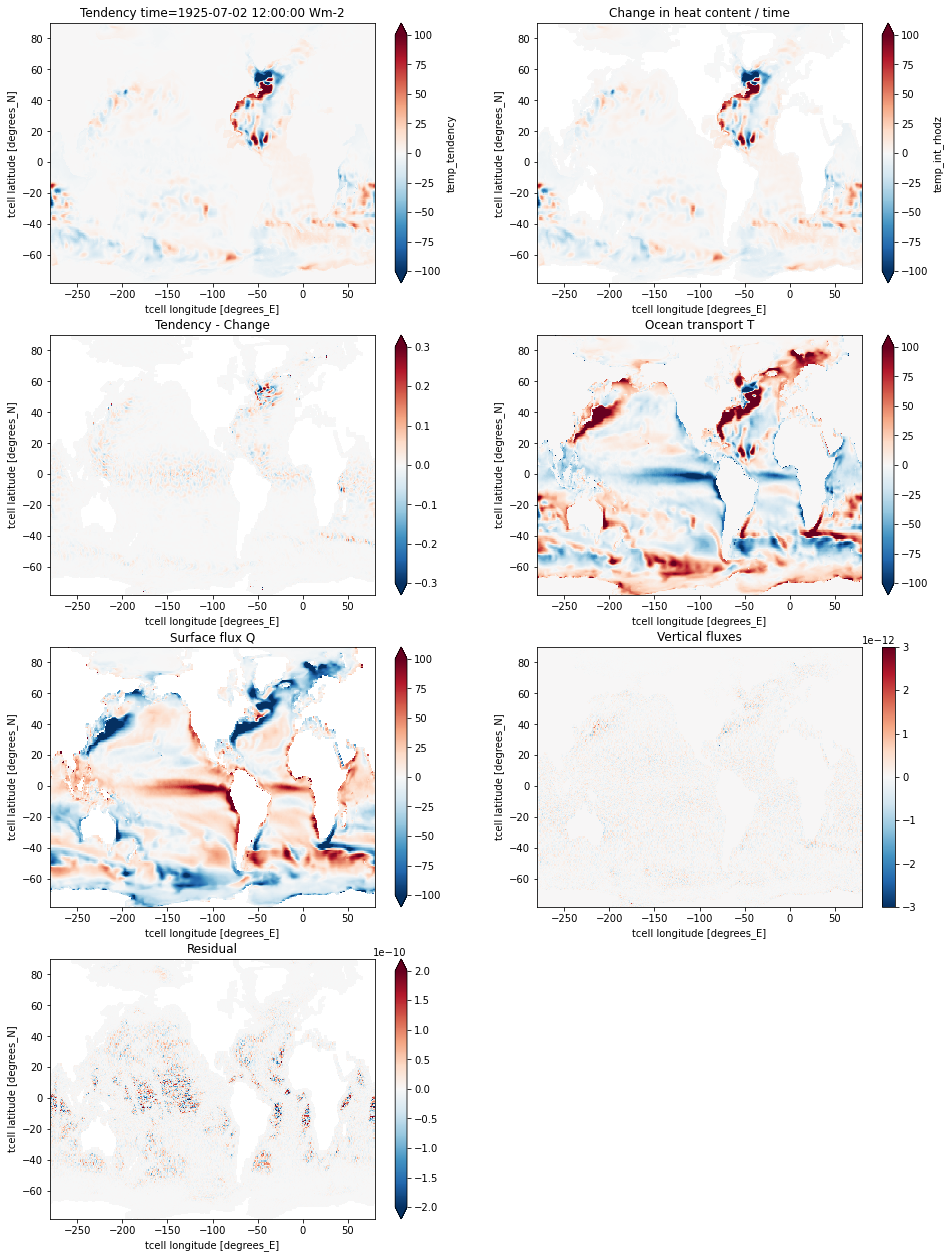

In [18]:
ind = 5
plt.figure(figsize=(16,22))
plt.subplot(4,2,1)
TEN.isel(time=ind).plot(vmin=-100.,vmax=100.,cmap='RdBu_r')
plt.title('Tendency time=' + str(time_avg.isel(time=ind).values) + ' Wm-2')
plt.subplot(4,2,2)
((Hsnap.isel(time=ind)-Hsnap.isel(time=ind-1))/dt.isel(time=ind).values).plot(vmin=-100.,vmax=100.,cmap='RdBu_r')
plt.title('Change in heat content / time')
plt.subplot(4,2,3)
((Hsnap.isel(time=ind)-Hsnap.isel(time=ind-1))/dt.isel(time=ind).values-TEN.isel(time=ind)).plot(vmin=-.3,vmax=.3,cmap='RdBu_r')
plt.title('Tendency - Change')
plt.subplot(4,2,4)
T.isel(time=ind).plot(vmin=-100.,vmax=100.,cmap='RdBu_r')
plt.title('Ocean transport T')
plt.subplot(4,2,5)
Q.isel(time=ind).plot(vmin=-100.,vmax=100.,cmap='RdBu_r')
plt.title('Surface flux Q')
plt.subplot(4,2,6)
Vf.isel(time=ind).plot(vmin=-3.e-12,vmax=3.e-12,cmap='RdBu_r')
plt.title('Vertical fluxes')
plt.subplot(4,2,7)
(TEN-Q-Vf-T).isel(time=ind).plot(vmin=-2.e-10,vmax=2.e-10,cmap='RdBu_r')
plt.title('Residual')

Clearly the summed 3D tendencies close to a high accuracy (the last panel is the residual, with magnitude to be compared to the top left tendency, or middle right heat transport T, or surface flux Q). The vertical sum of the vertical fluxes is even smaller (bottom right). The actual change in heat content tendency calculated from the snapshots divided by the time-period (top right) does differ a little from the tendency by $\pm0.3$Wm$^{-2}$ (Tendency - Change panel).

Note on diagnostic precision: 
- The residual of the 3D tendencies is significantly smaller with double precision (~1e-10 residual on 100 Wm-2 tendency for annual average) than with single precision (2e-4 residual on 1000 Wm-2 tendency for monthly value).
- The difference between the integrated tendency and the heat content change is also significantly smaller with double precision diagnostics (0.3 residual on 100 Wm-2 change for annual average) than with single precision (50 on 1000 for monthly value).

### Global average

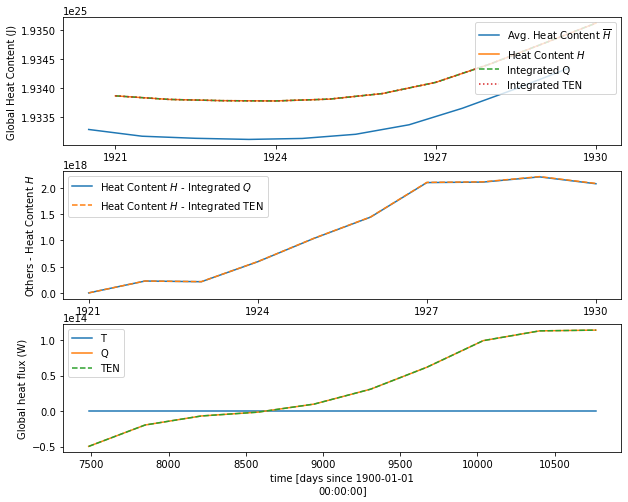

In [10]:
plt.figure(figsize=(10,8))
plt.subplot(3,1,1)
plt.plot(time_avg,(Hg).values,label='Avg. Heat Content $\overline{H}$')
plt.plot(time_snap,(Hsnapg).values,label='Heat Content $H$')
plt.plot(time_snap,timeInt(Qg)+Hsnapg[0].values,label='Integrated Q',linestyle='--')
plt.plot(time_snap,timeInt(TENg)+Hsnapg[0].values,label='Integrated TEN',linestyle=':')
plt.legend(loc=1)
plt.ylabel('Global Heat Content (J)')
plt.subplot(3,1,2)
# plt.plot(time_avg,(Hg).values-(Hsnapg).values,label='Avg. Heat Content $\overline{H}$')
plt.plot(time_snap,timeInt(Qg)+Hsnapg[0].values-(Hsnapg).values,label='Heat Content $H$ - Integrated $Q$')
plt.plot(time_snap,timeInt(TENg)+Hsnapg[0].values-(Hsnapg).values,label='Heat Content $H$ - Integrated TEN',linestyle='--')
plt.ylabel('Others - Heat Content $H$')
plt.legend()
plt.subplot(3,1,3)
Tg.plot(label='T')
Qg.plot(label='Q')
TENg.plot(label='TEN',linestyle='--')
plt.ylabel('Global heat flux (W)')
plt.legend()

The top plot shows a close correspondance between integrated Q, integrate-TEN and heat content snapshots. The averaged heat content (blue) is smaller than the snapshot heat content by ~5e21 (because the snapshots are the beginning of january - SO summer?). Clearly there is still somewhat of a mismatch between the integrated tendency terms and the difference from the snapshots (here reaching roughtly 2e18, vs. 3e19J for the monthly single-precision data). The ocean heat transport integrates to zero as it should.

## Long-term spatial changes in heat content

We now look at the spatial structure of these long term changes.

Firstly, the difference in heat content between snapshots at 1921-01-01 and 1930-01-01

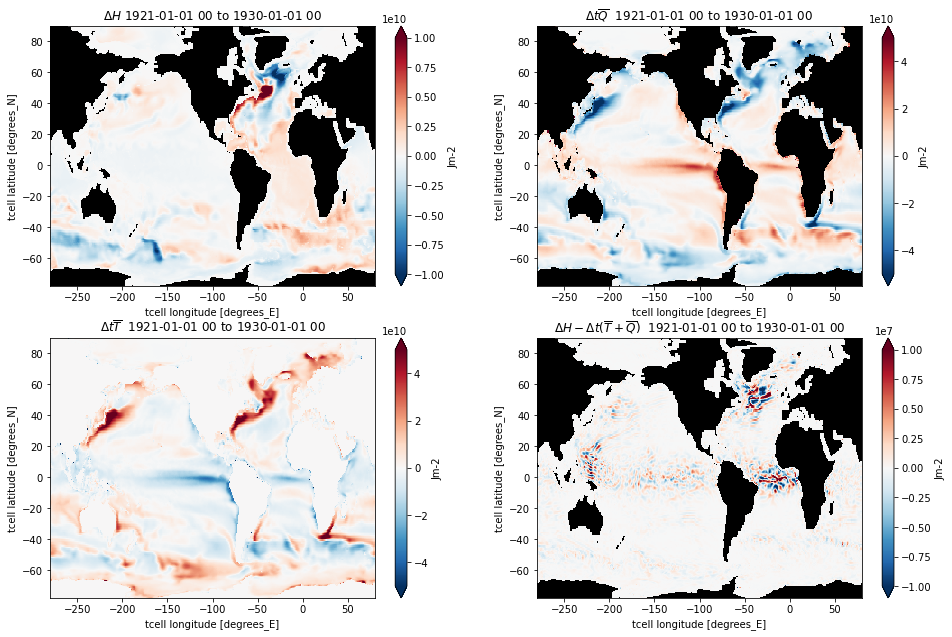

In [22]:
t0 = 1 # initial time (we drop the first year so we don't have to worry about getting a snapshot from the IC)
tf = len(time_snap.values) # final time
t0str = str(time_snap.isel(time=t0-1).values)[:13]
tfstr = str(time_snap.isel(time=tf-1).values)[:13]

DT = dt.isel(time=slice(t0,tf)).sum('time').values

plt.figure(figsize=(16,22))

plt.subplot(4,2,1)
dH = Hsnap.isel(time=tf-1)-Hsnap.isel(time=t0-1)
dH.plot(vmin=-1.e10,vmax=1.e10,cmap='RdBu_r',cbar_kwargs={'label':'Jm-2'})
plt.title('$\Delta H$ ' + t0str + ' to ' + tfstr)
plt.gca().set_facecolor('k')

plt.subplot(4,2,2)
(Q*DT).isel(time=slice(t0,tf)).mean('time').plot(vmin=-5.e10,vmax=5.e10,cmap='RdBu_r',cbar_kwargs={'label':'Jm-2'})
plt.title('$\Delta t \overline{Q}$  ' + t0str + ' to ' + tfstr)
plt.gca().set_facecolor('k')

plt.subplot(4,2,3)
(T*DT).isel(time=slice(t0,tf)).mean('time').plot(vmin=-5.e10,vmax=5.e10,cmap='RdBu_r',cbar_kwargs={'label':'Jm-2'})
plt.title('$\Delta t \overline{T}$  ' + t0str + ' to ' + tfstr)
plt.gca().set_facecolor('k')

plt.subplot(4,2,4)
(dH-((T+Q)*DT).isel(time=slice(t0,tf)).mean('time')).plot(vmin=-1.e7,vmax=1.e7,cmap='RdBu_r',cbar_kwargs={'label':'Jm-2'})
plt.title('$\Delta H - \Delta t (\overline{T} + \overline{Q})$  ' + t0str + ' to ' + tfstr)
plt.gca().set_facecolor('k')

Clearly the resulting heat content change (top left) is quite spatially variable (and it would be more in an eddying model). The error mismatch is quite small (1e7 here, where as it was much large - 3e9 for single precision output).

### Now the new risavg - difference between first and last years.

The below version only works if the first and last averaging periods are single diagnostic periods from the model.

In [53]:
# Make a function to construct the RA average as written above:
def RAavg(TEN,TENra,dt,t11,t12,t21,t22):
    
    # Simple average portion t12-t22 (flat):
    out = TEN.isel(time=slice(t12+1,t22+1)).mean('time')*dt.isel(time=slice(t12+1,t22+1)).sum('time').values
    
    # Rising average first period:
    if (t11 == t12):
        out = out + TENra.isel(time=t11)*dt.isel(time=t11).values
    else:
        print('FAIL!')
    
    # Rising average second period:
    if (t21 == t22):
        out = out - TENra.isel(time=t21)*dt.isel(time=t21).values
    else:
        print('FAIL!')
        
    return(out)

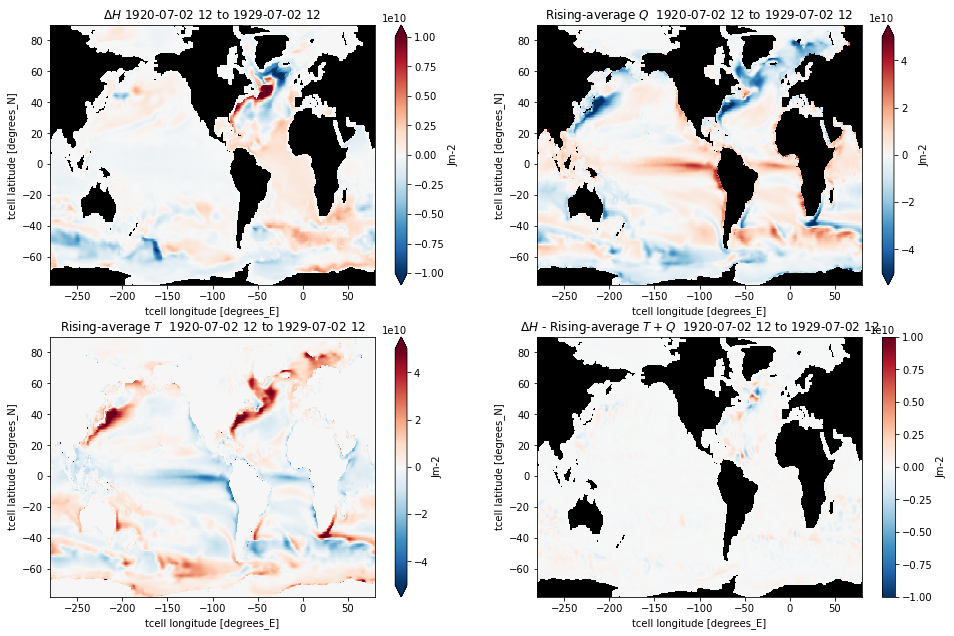

In [57]:
# first to last year:
t11 = 0
t12 = 0
t22 = len(time_avg.values)-1
t21 = len(time_avg.values)-1
t0str = str(time_avg.isel(time=t11).values)[:13]
tfstr = str(time_avg.isel(time=t21).values)[:13]

# # Block to block:
# nyr = 4
# t11 = 0
# t12 = nyr
# t22 = len(time_avg.values)-1
# t21 = len(time_avg.values)-nyr-1
# t0str = str(time_avg.isel(time=slice(t11,t12)).mean('time').values)[:4]
# tfstr = str(time_avg.isel(time=slice(t21,t22)).mean('time').values)[:4]

# Heat content difference from averages:
dH = H.isel(time=t21)-H.isel(time=t11)

Qd = RAavg(Q,Qra,dt,t11,t12,t21,t22)
Td = RAavg(T,Tra,dt,t11,t12,t21,t22)

plt.figure(figsize=(16,22))

plt.subplot(4,2,1)
dH.plot(vmin=-1.e10,vmax=1.e10,cmap='RdBu_r',cbar_kwargs={'label':'Jm-2'})
plt.title('$\Delta H$ ' + t0str + ' to ' + tfstr)
plt.gca().set_facecolor('k')

plt.subplot(4,2,2)
Qd.plot(vmin=-5.e10,vmax=5.e10,cmap='RdBu_r',cbar_kwargs={'label':'Jm-2'})
plt.title('Rising-average $Q$  ' + t0str + ' to ' + tfstr)
plt.gca().set_facecolor('k')

plt.subplot(4,2,3)
Td.plot(vmin=-5.e10,vmax=5.e10,cmap='RdBu_r',cbar_kwargs={'label':'Jm-2'})
plt.title('Rising-average $T$  ' + t0str + ' to ' + tfstr)
plt.gca().set_facecolor('k')

plt.subplot(4,2,4)
(dH-Qd-Td).plot(vmin=-1.e10,vmax=1.e10,cmap='RdBu_r',cbar_kwargs={'label':'Jm-2'})
plt.title('$\Delta H$ - Rising-average $T+Q$  ' + t0str + ' to ' + tfstr)
plt.gca().set_facecolor('k')

Unfortunately it's not obvious that this is any better than the above, because in the 1-degree model the snapshot difference is not that much noisier than the annual-average difference.

There is also a much larger residual in this rising average case - is this because of my time-step error discussed above? It seems to be doing something reasonable (i.e. if I remove the end-year risign average portions, or change their sign, I get a much larger residual).

Need to test at 1/4-degree with more variability? Or a 1-degree IAF run.

In [ ]:
# Use 2D Q tendencies

# surface heat flux:
Q = cc.querying.getvar(expt, 'sfc_hflux_coupler',session, n=n_files,decode_times=False
                       ,ncfile='ocean_month.nc') \
  + cc.querying.getvar(expt, 'sfc_hflux_pme',session, n=n_files,decode_times=False
                       ,ncfile='ocean_month.nc') \
  + cc.querying.getvar(expt, 'sfc_hflux_from_runoff',session, n=n_files,decode_times=False
                       ,ncfile='ocean_month.nc') \
  + cc.querying.getvar(expt, 'frazil_3d_int_z',session, n=n_files,decode_times=False
                       ,ncfile='ocean_month.nc')
Qra = cc.querying.getvar(expt, 'sfc_hflux_coupler',session, n=n_files,decode_times=False
                       ,ncfile='ocean_risavg.nc') \
  + cc.querying.getvar(expt, 'sfc_hflux_pme',session, n=n_files,decode_times=False
                       ,ncfile='ocean_risavg.nc') \
  + cc.querying.getvar(expt, 'sfc_hflux_from_runoff',session, n=n_files,decode_times=False
                       ,ncfile='ocean_risavg.nc') \
  + cc.querying.getvar(expt, 'frazil_3d_int_z',session, n=n_files,decode_times=False
                       ,ncfile='ocean_risavg.nc')

# ocean heat transport:
Fx = cc.querying.getvar(expt, 'temp_xflux_adv_int_z',session, n=n_files,decode_times=False
                       ,ncfile='ocean_month.nc') \
  + cc.querying.getvar(expt, 'temp_xflux_submeso_int_z',session, n=n_files,decode_times=False
                       ,ncfile='ocean_month.nc') \
  + cc.querying.getvar(expt, 'temp_xflux_gm_int_z',session, n=n_files,decode_times=False
                       ,ncfile='ocean_month.nc') \
  + cc.querying.getvar(expt, 'temp_xflux_ndiffuse_int_z',session, n=n_files,decode_times=False
                       ,ncfile='ocean_month.nc') \
  + cc.querying.getvar(expt, 'temp_sigma_diff_xflux_int_z',session, n=n_files,decode_times=False
                       ,ncfile='ocean_month.nc')
Fy = cc.querying.getvar(expt, 'temp_yflux_adv_int_z',session, n=n_files,decode_times=False
                       ,ncfile='ocean_month.nc') \
  + cc.querying.getvar(expt, 'temp_yflux_submeso_int_z',session, n=n_files,decode_times=False
                       ,ncfile='ocean_month.nc') \
  + cc.querying.getvar(expt, 'temp_yflux_gm_int_z',session, n=n_files,decode_times=False
                       ,ncfile='ocean_month.nc') \
  + cc.querying.getvar(expt, 'temp_yflux_ndiffuse_int_z',session, n=n_files,decode_times=False
                       ,ncfile='ocean_month.nc') \
  + cc.querying.getvar(expt, 'temp_sigma_diff_yflux_int_z',session, n=n_files,decode_times=False
                       ,ncfile='ocean_month.nc')
Sc = cc.querying.getvar(expt, 'temp_eta_smooth',session, n=n_files,decode_times=False
                       ,ncfile='ocean_month.nc') \
  + cc.querying.getvar(expt, 'mixdownslope_temp',session, n=n_files,decode_times=False
                       ,ncfile='ocean_month.nc').sum('st_ocean')
Fx_con = xr.concat([Fx.isel(xu_ocean=-1).fillna(0.),Fx.fillna(0.)],dim='xu_ocean').diff('xu_ocean').rename({'xu_ocean':'xt_ocean'}).assign_coords(xt_ocean=H.xt_ocean.values)
Fy_con = xr.concat([Fy.isel(yu_ocean=0).fillna(0.),Fy.fillna(0.)],dim='yu_ocean').diff('yu_ocean').rename({'yu_ocean':'yt_ocean'}).assign_coords(yt_ocean=H.yt_ocean.values)
T = -(Fx_con+Fy_con)/A + Sc

# ocean heat transport (ra):
Fxra = cc.querying.getvar(expt, 'temp_xflux_adv_int_z',session, n=n_files,decode_times=False
                       ,ncfile='ocean_risavg.nc') \
  + cc.querying.getvar(expt, 'temp_xflux_submeso_int_z',session, n=n_files,decode_times=False
                       ,ncfile='ocean_risavg.nc') \
  + cc.querying.getvar(expt, 'temp_xflux_gm_int_z',session, n=n_files,decode_times=False
                       ,ncfile='ocean_risavg.nc') \
  + cc.querying.getvar(expt, 'temp_xflux_ndiffuse_int_z',session, n=n_files,decode_times=False
                       ,ncfile='ocean_risavg.nc') \
  + cc.querying.getvar(expt, 'temp_sigma_diff_xflux_int_z',session, n=n_files,decode_times=False
                       ,ncfile='ocean_risavg.nc')
Fyra = cc.querying.getvar(expt, 'temp_yflux_adv_int_z',session, n=n_files,decode_times=False
                       ,ncfile='ocean_risavg.nc') \
  + cc.querying.getvar(expt, 'temp_yflux_submeso_int_z',session, n=n_files,decode_times=False
                       ,ncfile='ocean_risavg.nc') \
  + cc.querying.getvar(expt, 'temp_yflux_gm_int_z',session, n=n_files,decode_times=False
                       ,ncfile='ocean_risavg.nc') \
  + cc.querying.getvar(expt, 'temp_yflux_ndiffuse_int_z',session, n=n_files,decode_times=False
                       ,ncfile='ocean_risavg.nc') \
  + cc.querying.getvar(expt, 'temp_sigma_diff_yflux_int_z',session, n=n_files,decode_times=False
                       ,ncfile='ocean_risavg.nc')
Scra = cc.querying.getvar(expt, 'temp_eta_smooth',session, n=n_files,decode_times=False
                       ,ncfile='ocean_risavg.nc') \
  + cc.querying.getvar(expt, 'mixdownslope_temp',session, n=n_files,decode_times=False
                       ,ncfile='ocean_risavg.nc').sum('st_ocean')
Fxra_con = xr.concat([Fxra.isel(xu_ocean=-1).fillna(0.),Fxra.fillna(0.)],dim='xu_ocean').diff('xu_ocean').rename({'xu_ocean':'xt_ocean'}).assign_coords(xt_ocean=H.xt_ocean.values)
Fyra_con = xr.concat([Fyra.isel(yu_ocean=0).fillna(0.),Fyra.fillna(0.)],dim='yu_ocean').diff('yu_ocean').rename({'yu_ocean':'yt_ocean'}).assign_coords(yt_ocean=H.yt_ocean.values)
Tra = -(Fxra_con+Fyra_con)/A + Sc